# HuggingFace 프로젝트

## 결과 정리

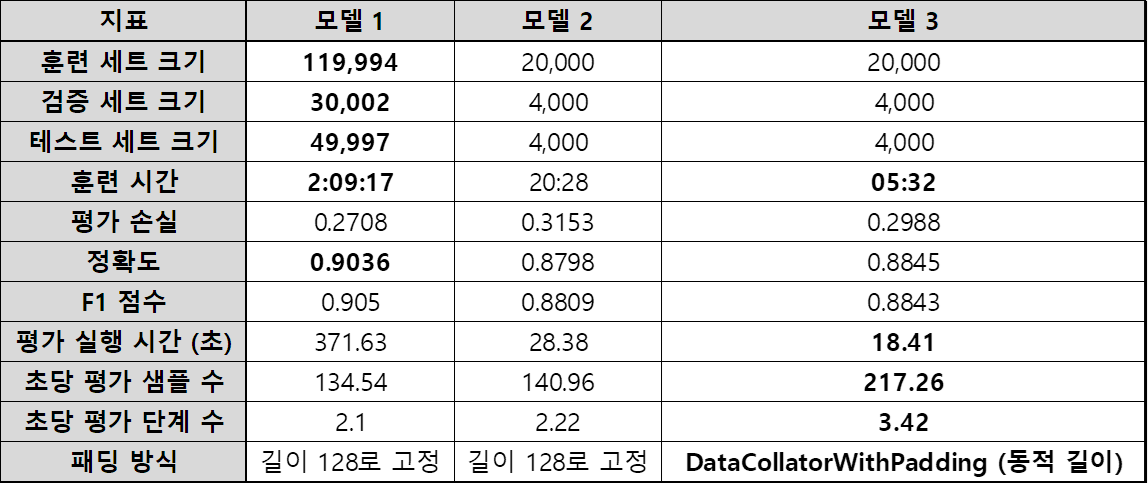

- 첫 번째 시도(모델 1):
    - 전체 데이터를 학습에 사용하였다. 훈련 시간은 2시간이며, 90%의 정확도가 나왔다.
- 두 번째 시도(모델 2):
    - 전체 데이터 중 일부만을 학습에 사용하였다. 훈련 시간은 20분이며 87%의 정확도가 나왔다.
- 세 번째 시도(모델 3):
    - 전체 데이터 중 일부만을 학습에 사용하였다. 훈련 시간은 5분 30초이며 88%의 정확도가 나왔다.

- 첫 번째와 두 번째 시도는 패딩의 크기를 128로 고정하여 학습을 진행하였다. 세 번째 시도에서는 버켓팅과 데이터 콜레이터를 활용하여 패딩의 크기를 동적으로 변경하는 방법을 적용하였다. 학습 시간이 많이 단축된 것을 확인할 수 있었으며, 정확도에는 영향이 없는 것을 확인할 수 있었다.

- 매트릭에 따라서 성능 평가가 달라지는가를 이야기해보면 재밌을 듯하다.
    - load_metric('glue', 'mrpc') 이게 내가 세 모델에 사용한 매트릭이다.
    - load_metric('glue', 'sst2') 이 매트릭은 써봤는데 0.1%p 차이가 있긴 한데 이 차이는 매트릭 때문이라기 보다는, 랜덤으로 가중치를 초기화하는 과정에서 발생하는 차이가 아닐까 싶다.
    - 그냥 accuracy 사용하기

## 퍼실님의 피드백
- 모델 1과 모델 2를 비교하면, 모델 2에서 데이터 수를 줄였는데, 이 과정에서 어떻게 데이터를 줄였길래 정확도가 비슷한지 밝혀야 한다. 다음과 같은 예시가 있다.
    - 2%p 떨어진 게 무엇을 의미했는지
    - 데이터를 어떤 방식으로 줄였는지(모델 2에 들어간 데이터가 모델 1에 들어간 데이터를 대표할 수 있는지 등)
- 모델 2와 모델 3을 비교하면, 학습 시간이 크게 단축된 것을 볼 수 있다. 모델 2에서의 학습 시간이 유의미한 학습 시간이었는지를 밝힐 필요가 있다.
    - 모델 2에서 maxlength가 128보다 낮은 값으로 학습하여 학습 시간이 줄어든다면 동적 패딩으로 학습을 줄였다고 말하기가 어렵다.
    - 실제 maxlength를 64로 하니까 학습 시간이 줄어든다...!
- 실험 전개 과정에서의 논리성을 명확하게 밝혀야 할 필요가 있구나.

### 프로젝트 내용
- HuggingFace의 Transformers와 Datasets를 활용하여 네이버 영화 감성 분석을 시행하여 90% 이상의 accuracy를 얻어낸다.  


- KLUE를 활용한다.
    - https://huggingface.co/klue/bert-base  
    
- 데이터셋:
    - https://github.com/e9t/nsmc

### 데이터셋 불러오기
- 1. txt 파일을 pandas의 dataFrame으로 불러온다.
- 2. Dataset.from_pandas()를 이용하여 허깅페이스 데이터셋으로 변환한다.

In [1]:
import tensorflow
import numpy
import transformers
import datasets
import os
import pandas as pd

In [2]:
train_dir = os.getcwd() + "/data/ratings_train.txt"
test_dir = os.getcwd() + "/data/ratings_test.txt"

In [3]:
train_df = pd.read_csv(train_dir, sep='\t')
test_df = pd.read_csv(test_dir, sep='\t')

print(train_df.head())
print('\n')
print(test_df.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


In [4]:
# 결측치 제거하기
train_df = train_df.dropna(axis=0,  how='any')
test_df = test_df.dropna(axis=0,  how='any')

In [5]:
import re

# 한글, 영어, 숫자, 특수문자, 띄어쓰기 이외의 문자 제거
def preprocess_func(sentence):
    
    # sentence = re.sub(r'[^\uAC00-\uD7A3a-zA-Z0-9\s!@#$%^&*()_+=-{};:\'",.<>\/?]', '', sentence)
    
    return sentence

train_df['document'] = train_df['document'].apply(lambda x: preprocess_func(x))
test_df['document'] = test_df['document'].apply(lambda x: preprocess_func(x))


In [6]:
# id 칼럼은 필요가 없으니까 빼자.

train_df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

print(train_df.head())
print('\n')
print(test_df.head())

                                            document  label
0                                아 더빙.. 진짜 짜증나네요 목소리      0
1                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2                                  너무재밓었다그래서보는것을추천한다      0
3                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


                                            document  label
0                                                굳 ㅋ      1
1                               GDNTOPCLASSINTHECLUB      0
2             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


In [7]:
print(len(train_df))
print(len(test_df))

149995
49997


In [10]:
# pandas dataframe을 이제 huggingface에 맞는 dataset으로 변환하자.
# Dataset.from_pandas()를 쓰면 된다.
# 훈련 데이터가 149995개 있다.
# 이 훈련 데이터에서 20%를 떼어내어 검증 데이터셋으로 만들자.
print(len(train_df) * 0.2)
print(len(train_df) * 0.8)


from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df.loc[0:119996])
eval_dataset = Dataset.from_pandas(train_df.loc[119996:])
test_dataset = Dataset.from_pandas(test_df)


print(train_dataset)
print(eval_dataset)
print(test_dataset)


29999.0
119996.0
Dataset({
    features: ['document', 'label', '__index_level_0__'],
    num_rows: 119994
})
Dataset({
    features: ['document', 'label', '__index_level_0__'],
    num_rows: 30002
})
Dataset({
    features: ['document', 'label', '__index_level_0__'],
    num_rows: 49997
})


In [11]:
# __index_level_0__ 라는 피처가 생긴 것을 볼 수 있다. 필요 없으므로 지우자.

train_dataset = train_dataset.remove_columns('__index_level_0__')
eval_dataset = eval_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')
# train_dataset = train_dataset.remove_columns('label')
# test_dataset = test_dataset.remove_columns('label')
print(train_dataset)
print(eval_dataset)
print(test_dataset)


Dataset({
    features: ['document', 'label'],
    num_rows: 119994
})
Dataset({
    features: ['document', 'label'],
    num_rows: 30002
})
Dataset({
    features: ['document', 'label'],
    num_rows: 49997
})


### 모델과 토크나이저 불러오기
- AutoModelForSequenceClassification과 AutoTokenizer를 활용하여 klue/bert-base를 불러온다.
- AutoModel을 사용하기보다는 어떤 태스크를 할지 명확하게 지정하는 게 좋다.
- AutoModel로 하면 classification이라고 인식을 못하네.


In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 전처리 하기

In [13]:
def tokenize_function(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        max_length=128,
        return_token_type_ids=False
    )

In [14]:
# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/120 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [15]:
# 전처리 결과 확인하기.
for element in train_dataset[:1].values():
    print(element)
print('\n')    
for element in eval_dataset[:1].values():
    print(element)
print('\n')    
for element in test_dataset[:1].values():
    print(element)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
['아 더빙.. 진짜 짜증나네요 목소리']
[[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[0]


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Trainer를 통한 학습 진행하기

In [16]:
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getcwd()
print(output_dir)

training_args = TrainingArguments(
    output_dir,
    evaluation_strategy="epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = 3,
    weight_decay = 0.01,
)

/aiffel/aiffel/HuggingFace_custom_project


In [17]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc') # 이진 분류에 맞는 평가 지표를 선택한다.

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)


In [18]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_args,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=eval_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running training *****
  Num examples = 119994
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 5625


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.266600,0.235269,0.903973,0.904314
2,0.190600,0.234943,0.908939,0.908775
3,0.134800,0.261323,0.907006,0.907420


Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1000
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1500
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-1500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running E

TrainOutput(global_step=5625, training_loss=0.20318816528320313, metrics={'train_runtime': 7758.3635, 'train_samples_per_second': 46.399, 'train_steps_per_second': 0.725, 'total_flos': 2.367881098265088e+16, 'train_loss': 0.20318816528320313, 'epoch': 3.0})

In [20]:
trainer.save_model(output_dir + "/manual_saved_model")

Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/pytorch_model.bin


In [21]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running Evaluation *****
  Num examples = 49997
  Batch size = 64


{'eval_loss': 0.2708316743373871,
 'eval_accuracy': 0.9035942156529392,
 'eval_f1': 0.9049984232103437,
 'eval_runtime': 371.6291,
 'eval_samples_per_second': 134.535,
 'eval_steps_per_second': 2.104,
 'epoch': 3.0}

In [19]:
# 1. 메모리 초과 남
# training_args = TrainingArguments(
#     output_dir,
#     evaluation_strategy="epoch",
#     learning_rate = 2e-5,
#     per_device_train_batch_size = 128,
#     per_device_eval_batch_size = 128,
#     num_train_epochs = 3,
#     weight_decay = 0.01,
# )

# 1. 예상 훈련 시간이 1시간 28분이다.
# training_args = TrainingArguments(
#     output_dir,
#     evaluation_strategy="epoch",
#     learning_rate = 2e-5,
#     per_device_train_batch_size = 128,
#     per_device_eval_batch_size = 128,
#     num_train_epochs = 3,
#     weight_decay = 0.01,
# )


- 일단 테스트 세트에서 90% 이상의 정확도를 보였다. 성공이다.
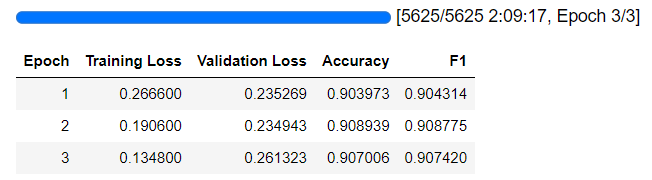